In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
#Constants
M = 100
R= 10
T=2
N=1000
sigma= 1/5
r= 0.02
c=1
K_eur=10
H_eur=0
K_but = 2
H_but = 3
K_bin = 2
H_bin = 3

In [3]:
#Practical function
def tridiag(lower, diag, upper, size):
    return np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)

### Initial Conditions function

In [4]:
def european_put(x, R=R):
    europe=np.array(K_eur-x)
    europe[int((K_eur*M)/R):]=0
    return europe

def butterfly(x, R=R):
    term1=np.array(x-K_but) #First term
    for i in range(len(term1)):
        term1[i] = max(term1[i], 0)
    term2=np.array(x-(K_but+H_but)) #Second term
    for i in range(len(term2)):
        term2[i] = max(term2[i], 0)
    term3=np.array(x-(K_but+2*H_but)) #Third term
    for i in range(len(term3)):
        term3[i] = max(term3[i], 0)
    butterfly=term1-2*term2+term3
    return butterfly

def binary(x, R=R):
    arr=np.ones(len(x))
    indices=np.where(x-K_bin<0)
    np.put(arr, indices, 0)
    return arr

#### Boundary conditions

In [5]:
def boundary_0(t=None, u_0=K_eur, x=None):  
    return u_0*np.exp(-c*t)

def boundary_R_eur(R, x=None, t=None):
    return max((K_eur-R), 0)

def boundary_R_but(R, x=None, t=None):
    butterfly=max(R-K_but, 0) - 2*max((R-(K_but+H_but)), 0) + max((R-(K_but+2*H_but)), 0)
    return butterfly

def boundary_R_bin(R, x=None, t=None):
    if (R-K_bin)<0:
        return 0
    else:
        return 1

#### Plotting functions

In [6]:
def plot_solution(U, angle=-30, title="Title"):        
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, R, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

In [7]:
def plot_two_solutions(U1, U2, angle=-30, title1="nr1", title2="nr2", title="Title"):   
    x1=np.linspace(0, R, len(U1[:,])) 
    t1=np.linspace(0, T, len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R, len(U2[:,])) 
    t2=np.linspace(0, T, len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

In [8]:
def plot_three_solutions(U1, U2, U3, angle=-30, title1="nr1", title2="nr2", title3="nr3", title="Title"
                        , R_val=None, T_val=None):
    if (R_val==None):
        R_val=np.ones(3)*R

    if (T_val==None):
        T_val=np.ones(3)*T
    
    x1=np.linspace(0, R_val[0], len(U1[:,])) 
    t1=np.linspace(0, T_val[0], len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R_val[1], len(U2[:,])) 
    t2=np.linspace(0, T_val[1], len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    x3=np.linspace(0, R_val[2], len(U3[:,])) 
    t3=np.linspace(0, T_val[2], len(U3[0]))
    tt3, xx3 = np.meshgrid(t3, x3)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    ax[2].plot_surface(tt3, xx3, U3, cmap=cm.coolwarm)
    ax[2].view_init(azim=angle)
    ax[2].set_title(title3)
    ax[2].set_xlabel('t')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

In [9]:
def plot_three_times(U1, angle=-30, title1="nr1", title2="nr2", title3="nr3", title="Title"):   
    U2=U1
    U3=U1
    x1=np.linspace(0, R, len(U1[:,])) 
    t1=np.linspace(0, T, len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R, len(U2[:,])) 
    t2=np.linspace(0, T, len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    x3=np.linspace(0, R, len(U3[:,])) 
    t3=np.linspace(0, T, len(U3[0]))
    tt3, xx3 = np.meshgrid(t3, x3)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), subplot_kw={"projection": "3d"})
    ax[0].plt(t1, U1[:,0], cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plt(t2, U2[:,len(t2)/2], cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    ax[2].plt(t3, U3[:,-1], cmap=cm.coolwarm)
    ax[2].view_init(azim=angle)
    ax[2].set_title(title3)
    ax[2].set_xlabel('t')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

### Forward Euler

In [10]:
import time



def forward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1, N+1))       
    x=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x, R=R) #Initial and boundary functions
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    beta_0 = 1-k*sigma**2*m**2 - k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    F = RHS_func(x,t)[1:-1,:]
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1] #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    
    A=tridiag(beta_neg1[2:-1], beta_0[1:-1] ,beta_1[1:-2], M-1)
    
    CFL=min(np.diag(A))
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n]) + G[:,n] + k*F[:,n]
    
    return U, CFL
time_euler1 = time.time()

### Forward euler with Neuman BC

We now need an extra node to acheive second order consistency, $U_{M+1}$.

In [11]:
def forward_euler_neuman(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1, N+1))       
    x=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x, R=R) #Initial and boundary functions
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    #U[-1,:]=BCR(R, x=x, t=t)
    
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    beta_0 = 1-k*sigma**2*m**2 - k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    F = RHS_func(x,t)[1:,:]
    G=np.zeros((M, N+1))
    
    G[0] = U[0, :]*beta_neg1[1] #Boundary conditions
    
    
    A=tridiag(beta_neg1[2:], beta_0[1:] ,beta_1[1:-1], M)
    A[-1, -2]= k*sigma**2*M**2
    A[-1, -1]= 1- k*sigma**2*M**2 - k*c
    
    CFL=min(np.diag(A))
    
    for n in range(N):
        U[1:, n+1]=A.dot(U[1:, n]) + G[:,n] + k*F[:,n]
    
    return U, CFL

### Backward Euler

In [12]:
def backward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)        
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x, R=R)  
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    alpha_0 = 1+k*sigma**2*m**2 + k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    A=tridiag(-beta_neg1[2:-1], alpha_0[1:-1], -beta_1[1:-2], M-1)
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1]  #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    F = RHS_func(x,t)[1:-1,:]
    
    CFL=np.diag(A)
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, U[1:-1, n]+G[:,n+1] + k*F[:,n+1])
        
    return U, CFL

### Crank-Nicolson

In [26]:
def crank_nicolson(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)         #How to choose M?
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x, R=R)
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1_np1 = k*sigma**2*m**2/4 - k*r*m/4
    alpha_0_np1 = 1+k*sigma**2*m**2/2 + k*c/2
    beta_1_np1 = k*sigma**2*m**2/4 + k*r*m/4
    
    #n - coefficients
    beta_neg1_n = k*sigma**2*m**2/4 - k*r*m/4
    beta_0_n = 1-k*sigma**2*m**2 /2- k*c/2
    beta_1_n = k*sigma**2*m**2/4 + k*r*m/4
    
    #Matrices
    A=tridiag(-beta_neg1_np1[2:-1], alpha_0_np1[1:-1], -beta_1_np1[1:-2],  M-1)
    B=tridiag(beta_neg1_n[2:-1], beta_0_n[1:-1], beta_1_n[1:-2],  M-1)
    
    #Boundary conditions
    G=np.zeros((M-1, N))
    G[0] = U[0, :-1]*beta_neg1_n[1] + U[0, 1:]*beta_neg1_np1[1]
    G[-1] = U[-1,:-1]*beta_neg1_n[-2] + U[-1, 1:]*beta_neg1_np1[-2]
    
    #RHS
    F = RHS_func(x,t)[1:-1,:]
    
    #Check CFL
    CFL=min(np.diag(A))
    
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, np.dot(B, U[1:-1, n])+G[:,n] + k*(F[:,n] + F[:,n+1])/2 )
    
    return U, CFL

### Problem 1 e)

## TEST THE SCHEMES

We now define a nice analytic function $v(x,t)=t + x^2$ and find an appropriate right hand side in the linear BS-equation. We see that 
$$
v_t - \frac12 \sigma^2 x^2 v_{xx} - r x v_x + c v = \partial_t(t+x^2) - \frac12 \sigma^2 x^2 \partial_{xx}(t + x^2) - rx \partial_x(t + x^2) + c(t+x^2) = \underbrace{ 1 - \sigma^2 x^2 - 2rx^2 + c(t+x^2)}_{\text{RHS}}.
$$

In this way, we can compare our schemes to an analytic solution. We define it below.

In [14]:
def v_exact_func(t, x):  
    return np.sin(x)*np.exp(-t)

The boundary conditions are easily found by inserting $x=0$ and $x=R$ into our analytical solution, yielding in
$$
v(0,t) = t, \qquad v(R,t) = R^2 + t,
$$
and similiarily, the initial condition is similarily found to be
$$
v(x, 0) = x^2.
$$
We define these functions together with RHS:

In [15]:
def an_initial(x, R=R):
    return np.sin(x)

def an_boundary_0(t=None, u_0=K_eur, x=None):
    return 0

def an_boundary_R(R, x=None, t=None):
    return np.sin(R)*np.exp(-t)

def RHS_analytic(xx,tt):
    t, x = np.meshgrid(tt, xx)
    return -np.exp(-t)*np.sin(x) + 1/2*sigma**2*x**2 *np.exp(-t)*np.sin(x) - \
r*x*np.exp(-t)*np.cos(x) + c*np.exp(-t)*np.sin(x)


#3*t**2 + 1/2*sigma**2 *x**2 * np.sin(x) - r*x*np.cos(x) + c*(np.sin(x) + t**3)

We then solve the equation by Forward Euler and Crank-Nicolson,

In [28]:
#Define the analytical function
x=np.linspace(0, R, M+1)   
t=np.linspace(0, T, N+1)
tt, xx = np.meshgrid(t,x)
v_exact = v_exact_func(tt,xx)

#Numerical solution
time_euler0 = time.time()
v_forward, CFL_forward = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
time_euler1 = time.time()

time_neumann_euler0 = time.time()
v_forward_neumann, CFL_forward_neumann = forward_euler_neuman(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
time_neumann_euler1 = time.time()

time_backward_euler0 = time.time()
v_backward, CFL_backward = backward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
time_backward_euler1 = time.time()

time_crank0 = time.time()
v_CN, CFL_CN = crank_nicolson(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
time_crank1 = time.time()



and compare the results:

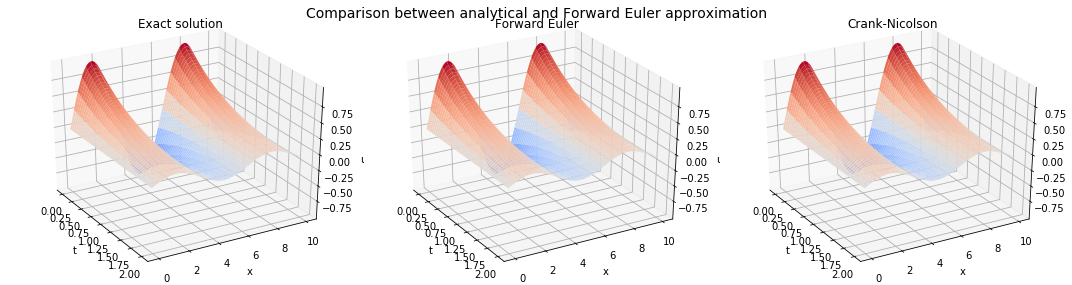

In [40]:
plot_three_solutions(v_exact, v_forward, v_CN, angle=-30, 
                   title1="Exact solution", title2="Forward Euler", title3="Crank-Nicolson",
                   title="Comparison between analytical and Forward Euler approximation")


and they seem to look good.

## CFL-TESTING

We have in our derivation for the monotonicity of our methods, that we needed certain requirements related to our constants. Let us inspect what happens when these requirements are not fulfilled for the forward euler method. Recall that our CFL condition was that $\xi_m = 1- k \sigma^2 m^2 - kc \geq 0, \quad m=1, \dots, M-1$. The monotonicity guarantees stability, and if the requirement is unsatisfied, this is no longer guaranteed.

We first want to check what happens when the CFL condition $\xi_m = 1- k \sigma^2 m^2 - kc \geq 0$ doesn't hold. For example, we can let $\sigma=1/4$ instead of $1/5$ such that the left hand side is negative.

The quantity /xi_m gains a minimum at -0.227


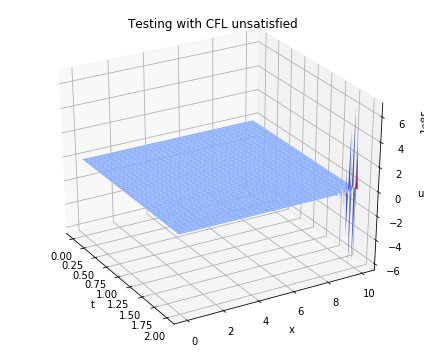

In [18]:
sigma=0.25
v_forward_CFL, CFL_forward_CFL = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
print("The quantity /xi_m gains a minimum at", round(CFL_forward_CFL, 3))
plot_solution(v_forward_CFL, angle=-30, title="Testing with CFL unsatisfied")
sigma=1/5

We see that the result is drastic.

## CONVERGENCE RATES

We now want to see what happens with the error $e(h, k)= U - u$ when we vary $h$. In that way, we can find the convergence rate. First, we simply want to inspect $e(h,k)$ with a fixed $k$, so we let $k$ stand as it is. We define an array of $h$'s (and $M$'s).

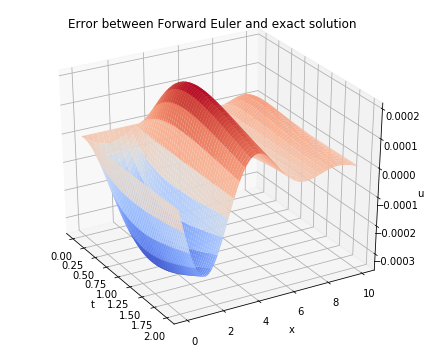

In [19]:
plot_solution(v_forward - v_exact , angle=-30, title="Error between Forward Euler and exact solution")

To evaluate the error for a particular $h$, it is reasonable to assume that the error is greatest at $t=T=2$. For evaluating the error, we thus look at the 2-norm error between the exact solution and the numerical solution at $t=2$. We define a function who find the error between two solutions:

In [20]:
N=10000
sigma= 0.5
r= 0.05


#Define an error function for a method
def error_func_h(method, u_exact_method):
    Ms=np.arange(2,10,1)
    hs=R/Ms
    t=np.linspace(0, T, N+1)
    error= np.zeros(len(hs))
    for i in range(len(Ms)):
        u_numeric, temp = method(R, Ms[i], T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                           an_initial, RHS_func=RHS_analytic)
        x = np.linspace(0, R, Ms[i]+1)
        tt, xx = np.meshgrid(t,x )
        u_exact = u_exact_method(tt, xx)
        error[i] = np.max( np.abs(u_numeric[:,-1] - u_exact[:,-1] ))
    order = np.polyfit(np.log(hs),np.log(error),1)[0]
    return hs, error , order

hs, error_forward_h, order_forward_h = error_func_h(forward_euler, v_exact_func)
hs, error_backward_h, order_backward_h = error_func_h(backward_euler, v_exact_func)
hs, error_crank_h, order_crank_h = error_func_h(crank_nicolson, v_exact_func)

print("Order of h, Forward =", order_forward_h)
print("h, Backward =", order_backward_h)
print("h, Crank =", order_crank_h)
N=1000
sigma= 1/5
r= 0.02

Order of h, Forward = 2.160586384944002
h, Backward = 2.160415646294544
h, Crank = 2.0812414132897468


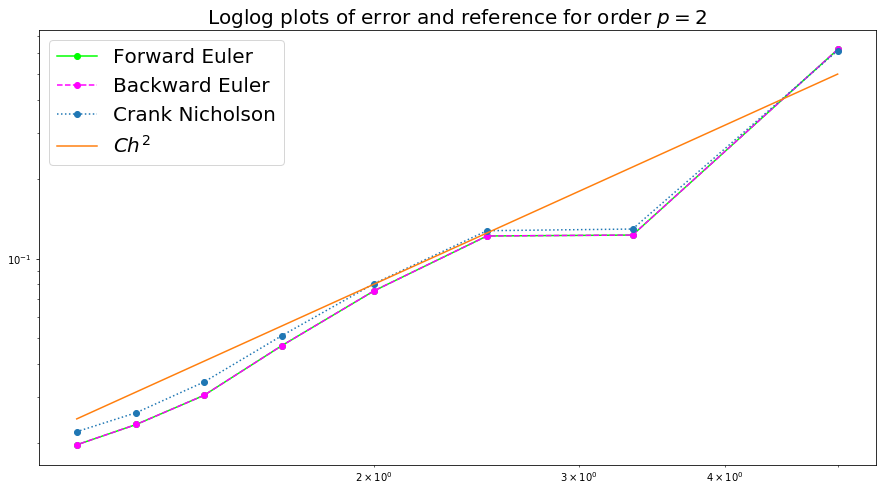

In [21]:
plt.figure(figsize=(15,8))
plt.title(r'Loglog plots of error and reference for order $p=2$', fontsize=20)
plt.loglog(hs, error_forward_h,'o-', linestyle='-', color="lime", label="Forward Euler")
plt.loglog(hs, error_backward_h, 'o-', linestyle='--',  color="magenta", label="Backward Euler")
plt.loglog(hs, error_crank_h,'o-', linestyle=':', label="Crank Nicholson")
plt.loglog(hs, 0.02*hs**2, label=r'$Ch^{2}$')
plt.legend(fontsize=20)

In [83]:
##### Define an error function for a method
sigma= 1/5       #1/5 originally
r= 0.02           #0.02 originally
M=100             #100 originally
R=2               #2 originally
c=1

def error_func_k(method, u_exact_func):
    T=1
    N=400
    P=4
    ks=np.zeros(P)
    error= np.zeros(P)
    x= np.linspace(0, R, M+1)
    for i in range(P):
        u_numeric, temp = method(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                           an_initial, RHS_func=RHS_analytic)
        t = np.linspace(0, T, N+1)
        tt, xx = np.meshgrid(t,x )
        u_exact = u_exact_func(tt, xx)
        error[i] = np.max( np.abs(u_numeric - u_exact ))
        ks[i] = t[1] - t[0]
        N=2*N
    order = np.polyfit(np.log(ks),np.log(error),1)[0]
    return ks, error , order

ks, error_forward_k, order_forward_k = error_func_k(forward_euler, v_exact_func)
ks, error_backward_k, order_backward_k = error_func_k(backward_euler, v_exact_func)
ks, error_crank_k, order_crank_k = error_func_k(crank_nicolson, v_exact_func)

print("k, Forward =", order_forward_k)
print("k, Backward =", order_backward_k)
print("k, Crank =", order_crank_k)
M=100
N=1000

k, Forward = 1.003136679313971
k, Backward = 0.9968537237140652
k, Crank = 8.656969744966155e-06


In [23]:
#Define an error function for a method
M=10
N=10000
R=10
def error_func_k(method, u_exact_func): 
    T=1
    N=1
    P=4
    ks=np.zeros(P)
    error= np.zeros(P)
    x= np.linspace(0, R, M+1)
    N=400
    for i in range(P):
        u_numeric, temp = method(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                           an_initial, RHS_func=RHS_analytic)
        t = np.linspace(0, T, N+1)
        tt, xx = np.meshgrid(t,x )
        u_exact = u_exact_func(tt, xx)
        error[i] = np.max( np.abs(u_numeric - u_exact ))
        ks[i] = T/N
        N=2*N
    order = np.polyfit(np.log(ks),np.log(error),1)[0]
    return ks, error , order

#ks, error_forward_k, order_forward_k = error_func_k(forward_euler, v_exact_func)
#ks, error_backward_k, order_backward_k = error_func_k(backward_euler, v_exact_func)
ks, error_crank_k, order_crank_k = error_func_k(crank_nicolson, v_exact_func)

print("k, Crank =", error_crank_k, order_crank_k)
M=100
N=1000

k, Crank = [0.03426878 0.03426876 0.03426875 0.03426875] 4.600857931042749e-07


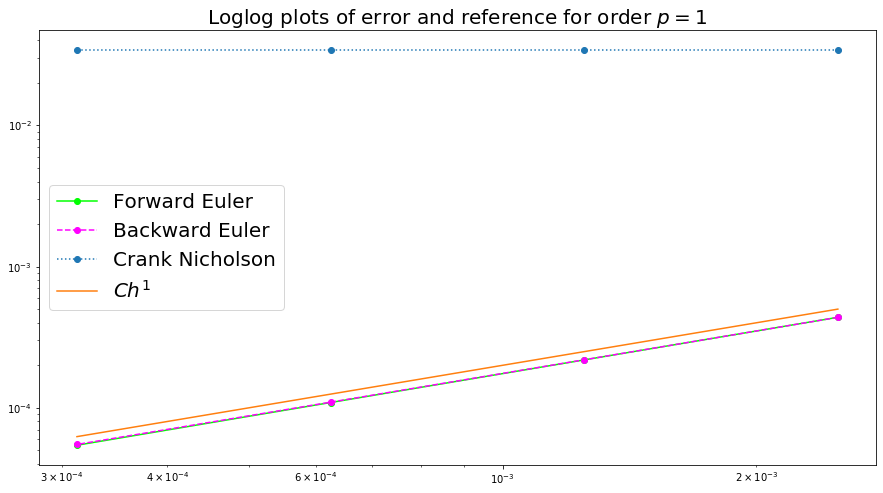

In [44]:
plt.figure(figsize=(15,8))
plt.title(r'Loglog plots of error and reference for order $p=1$', fontsize=20)
plt.loglog(ks, error_forward_k,'o-', linestyle='-', color="lime", label="Forward Euler")
plt.loglog(ks, error_backward_k, 'o-', linestyle='--',  color="magenta", label="Backward Euler")
plt.loglog(ks, error_crank_k,'o-', linestyle=':', label="Crank Nicholson")
plt.loglog(ks, 0.2*ks, label=r'$Ch^{1}$')
plt.legend(fontsize=20)

#### Timing the schemes

In [32]:
time_euler=time_euler1-time_euler0
time_neumann_euler=time_neumann_euler1-time_neumann_euler0
time_backward_euler=time_backward_euler1-time_backward_euler0
time_crank=time_crank1-time_crank0

print("Time for Euler scheme with Dirichlet BC's: ", time_euler)
print("Time for Euler scheme with Neumann BC's: ", time_neumann_euler)
print("Time for backward Euler scheme: ", time_backward_euler)
print("Time for Crank-Nicholson scheme: ", time_crank)

Time for Euler scheme with Dirichlet BC's:  0.017950773239135742
Time for Euler scheme with Neumann BC's:  0.021940946578979492
Time for backward Euler scheme:  0.11784887313842773
Time for Crank-Nicholson scheme:  0.1253647804260254


### 1 f) Different choices of BC's

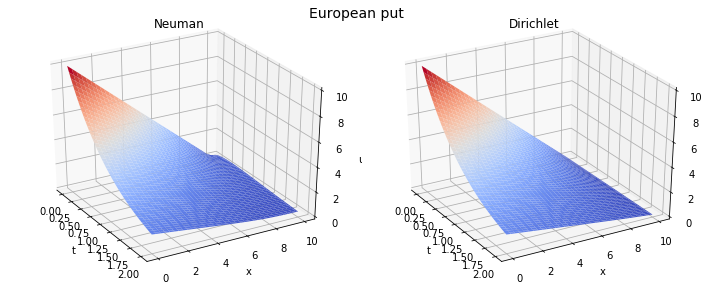

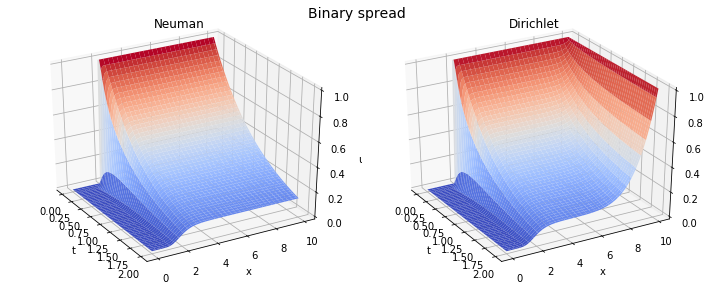

In [33]:
u_european_neuman, CFL_european_neuman = forward_euler_neuman(R, M, T, N, sigma, r, c, K_eur, H_eur, 
                                                            boundary_0, boundary_R_eur, european_put)
u_european_dirich, CFL_european_dirich = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, 
                                                            boundary_0, boundary_R_eur, european_put)
plot_two_solutions(u_european_neuman, u_european_dirich, angle=-30, title="European put", 
                   title1="Neuman", title2="Dirichlet")

u_binary_neuman, CFL_european_neuman = forward_euler_neuman(R, M, T, N, sigma, r, c, K_bin, H_bin, 
                                                            boundary_0, boundary_R_bin, binary)
u_binary_dirich, CFL_european_dirich = forward_euler(R, M, T, N, sigma, r, c, K_bin, H_bin, 
                                                            boundary_0, boundary_R_bin, binary)
plot_two_solutions(u_binary_neuman, u_binary_dirich, angle=-30, title="Binary spread", 
                   title1="Neuman", title2="Dirichlet")

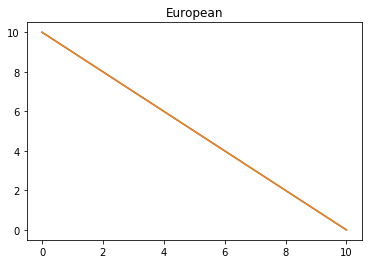

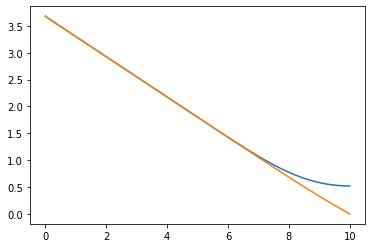

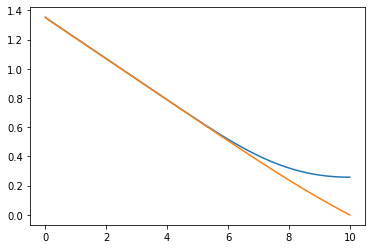

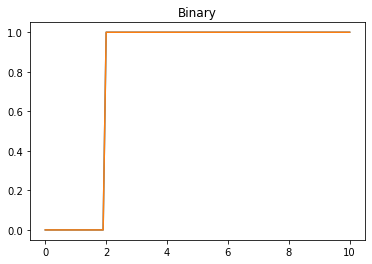

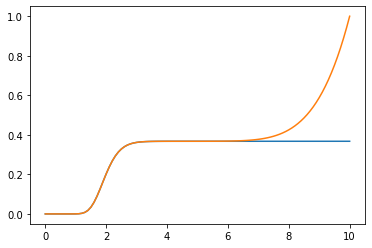

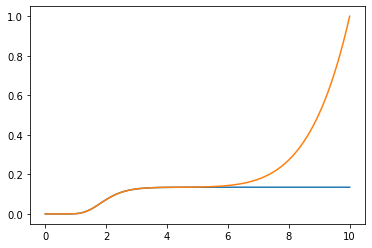

In [34]:
plt.title("European")
plt.plot(x, u_european_neuman[:,0])
plt.plot(x, u_european_dirich[:,0])
plt.show()
plt.plot(x, u_european_neuman[:,500])
plt.plot(x, u_european_dirich[:,500])
plt.show()
plt.plot(x, u_european_neuman[:,-1])
plt.plot(x, u_european_dirich[:,-1])
plt.show()

plt.plot(x, u_binary_neuman[:,0])
plt.plot(x, u_binary_dirich[:,0])
plt.title("Binary")
plt.show()
plt.plot(x, u_binary_neuman[:,500])
plt.plot(x, u_binary_dirich[:,500])
plt.show()
plt.plot(x, u_binary_neuman[:,-1])
plt.plot(x, u_binary_dirich[:,-1])
plt.show()

10
4
4


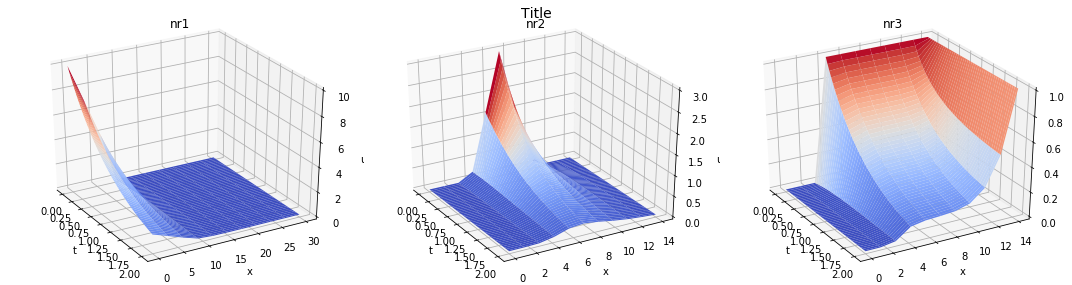

In [35]:
#european
R_eur= 2*K_eur + 10
R_but= 2*K_but + 10
R_bin= 2*K_bin + 10
K_but=4
K_bin=4

M=10

u_check1, CFL_forward1 = forward_euler(R_eur, M, T, N, sigma, r, c, K_eur, H_eur, boundary_0, boundary_R_eur, 
                       european_put)
#butterfly
u_check2, CFL_forward2 = forward_euler(R_but, M, T, N, sigma, r, c, K_but, H_but, boundary_0, boundary_R_but, 
                       butterfly)
#binary
u_check3, CFL_forward3 = forward_euler(R_bin, M, T, N, sigma, r, c, K_bin, H_bin, boundary_0, boundary_R_bin, 
                       binary)

print(K_eur)
print(K_but)
print(K_bin)

plot_three_solutions(u_check1, u_check2, u_check3, angle=-30, title1="nr1", title2="nr2", title="Title", 
                     R_val=[R_eur, R_but, R_bin])

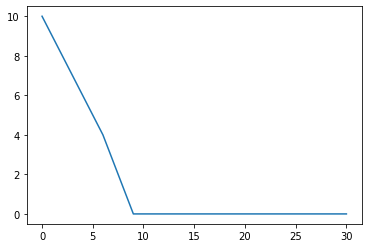

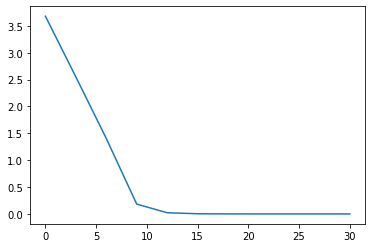

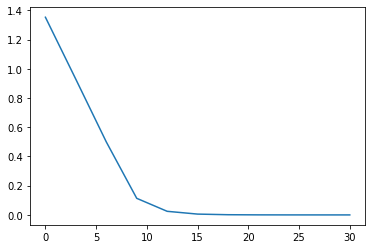

In [36]:
plt.plot(np.linspace(0,R_eur, M+1) , u_check1[:,0])
plt.show()
plt.plot(np.linspace(0,R_eur, M+1), u_check1[:,500])
plt.show()
plt.plot(np.linspace(0,R_eur, M+1), u_check1[:,-1])
plt.show()

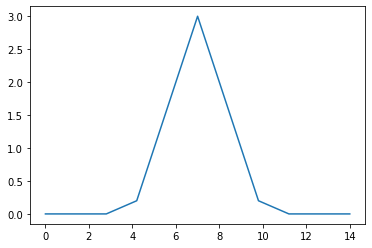

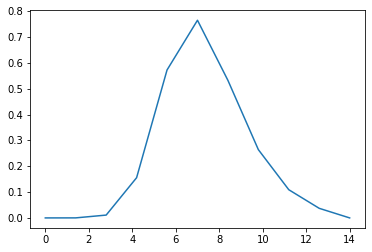

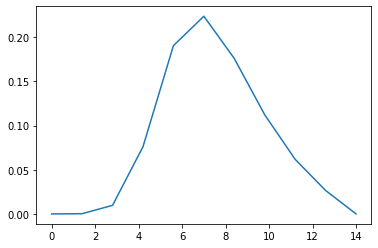

In [37]:
plt.plot(np.linspace(0,R_but, M+1) , u_check2[:,0])
plt.show()
plt.plot(np.linspace(0,R_but, M+1), u_check2[:,500])
plt.show()
plt.plot(np.linspace(0,R_but, M+1), u_check2[:,-1])
plt.show()

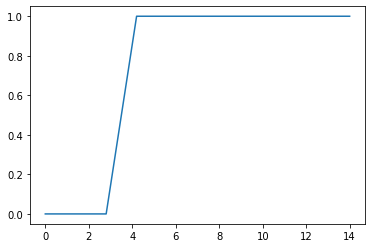

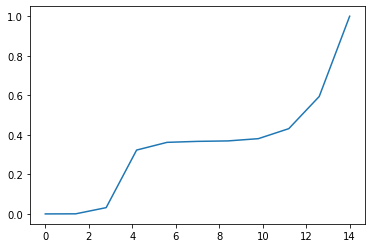

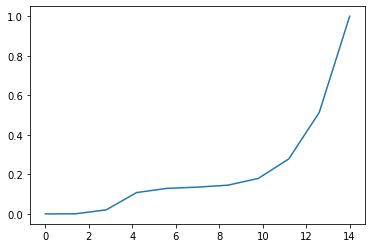

In [38]:
plt.plot(np.linspace(0,R_bin, M+1) , u_check3[:,0])
plt.show()
plt.plot(np.linspace(0,R_bin, M+1), u_check3[:,500])
plt.show()
plt.plot(np.linspace(0,R_bin, M+1), u_check3[:,-1])
plt.show()